## Final Project Submission

Please fill out:
* Student name: Htoo Aung Latt
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL: https://medium.com/@jimmy.latt/first-data-science-project-the-tools-293d35b1a81d


# Movie Gross and Rating Analysis

The goal of this project is to analyse what sort of movie a new movie production company should make.

I will be using only the given dataset so there are a few limitations to analysis I can do.

The biggest difficulty I found with the data is that there is no uniquie id for movies across diffrent datasets. So I am force to used the movie titles as the index while joining together the data. This is not ideal because there are movies with the same name which will have to be dropped.

Another limitation is that the dataset that I will be using from imdb only goes back to 2010. When trying to find the average and total gross my data will only start from 2010.

The two given dataset from rottentomatoes seems to be completely useless for me since they do not even include the movie titles.


In [1]:
### Import initial libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
###Read in the Dataset
bomgross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
imdbstaff = pd.read_csv('zippedData/imdb.name.basics.csv.gz') ##crew code
imdbdf2 = pd.read_csv('zippedData/imdb.title.akas.csv.gz') ##Doesn't seem useful
imdbdf3 = pd.read_csv('zippedData/imdb.title.basics.csv.gz')##Movie title, code, genres
imdbcrew = pd.read_csv('zippedData/imdb.title.crew.csv.gz')##Director and writers code
imdbcrew2 = pd.read_csv('zippedData/imdb.title.principals.csv.gz') ##crew for each movie and characters
ratingsdf = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')##Ratings

rtdf = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')##director writer genre
rt_revi_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin-1')
tmdbdf = pd.read_csv('zippedData/tmdb.movies.csv.gz')
budgetdf = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

genresid = {"28": "Action", "12": "Adventure", "16": "Animation", "35": "Comedy", "80": "Crime", "99": "Documentary", "18": "Drama", "10751": "Family",
    "14": "Fantasy", "36": "History", "27": "Horror", "10402": "Music", "9648": "Mystery", "10749": "Romance", "878": "Science Fiction", "10770": "TV Movie",
    "53": "Thriller", "10752": "War", "37": "Western"} 

# Initial Data Cleaning

In [3]:
budgetdf.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


First thing I need to do is change currency which are given as strings into floats.

In [4]:
###Change the Currency Strings into Float
budgetdf['worldwide_gross'] = budgetdf['worldwide_gross'].apply(lambda x:x.strip('$')).apply(lambda x:x.replace(',','')).astype(float)
budgetdf['domestic_gross'] = budgetdf['domestic_gross'].apply(lambda x:x.strip('$')).apply(lambda x:x.replace(',','')).astype(float)
budgetdf['production_budget'] = budgetdf['production_budget'].apply(lambda x:x.strip('$')).apply(lambda x:x.replace(',','')).astype(float)

### Change the Currency into terms of Millions
budgetdf['worldwide_gross'] = budgetdf['worldwide_gross'].apply(lambda x: x/1000000)
budgetdf['domestic_gross'] = budgetdf['domestic_gross'].apply(lambda x: x/1000000)
budgetdf['production_budget'] = budgetdf['production_budget'].apply(lambda x: x/1000000)

In [5]:
budgetdf.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425.0,760.507625,2776.345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.063875,1045.663875
2,3,"Jun 7, 2019",Dark Phoenix,350.0,42.762350,149.762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330.6,459.005868,1403.013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317.0,620.181382,1316.721747


In [6]:
###Replacing genre codes with genre names
tmdbdf['genre_ids'] = tmdbdf['genre_ids'].apply(lambda x: x.replace('[',''))
tmdbdf['genre_ids'] = tmdbdf['genre_ids'].apply(lambda x: x.replace(']',''))
tmdbdf['genre_ids'] = tmdbdf['genre_ids'].apply(lambda x: x.split(','))
tmdbdf = tmdbdf.explode('genre_ids')
tmdbdf['genre_ids'] = tmdbdf['genre_ids'].apply(lambda x: x.strip(' '))
tmdbdf['genre_ids'] = tmdbdf['genre_ids'].map(genresid)
tmdbdf['genre_ids'].isna().sum()
tmdbdf.rename(columns={'title': 'primary_title'},inplace=True)


The main dataset that I will be using have a lot of duplicates, first I dropped the one sharing the same id since I can be sure that the information I need from them are all identical. 

Then I have no choice but to drop all the rows with the same titles since there is no other way than the movie title to join them with box office informations. Since the movies sharing the same titles are diffrent films, I have to drop all of them to ensure that the wrong movie doesn't get join with box office information.

In [7]:
imdbdf2.head()

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0


In [8]:
print(imdbdf2['title_id'].duplicated().sum())
print(imdbdf2['title'].duplicated().sum())

### Drop duplicates rows but keep the first entry
imdbdf2['title_id'].duplicated().sum()
imdbdf2.drop_duplicates(subset ="title_id", keep = 'first', inplace=True) 

print(imdbdf2['title_id'].duplicated().sum())
print(imdbdf2['title'].duplicated().sum())

### Drop all the duplicate rows
imdbdf2.drop_duplicates(subset ="title", keep = False, inplace=True) 

209401
78922
0
5858


In [9]:
budgetdf.loc[budgetdf['movie'].duplicated()].head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
273,74,"May 19, 1998",Godzilla,125.0,136.314294,376.000000
408,9,"Nov 21, 2018",Robin Hood,99.0,30.824628,84.747441
484,85,"Jul 8, 2005",Fantastic Four,87.5,154.696080,333.132750
543,44,"May 7, 1999",The Mummy,80.0,155.385488,416.385488
707,8,"Jun 13, 1997",Hercules,70.0,99.112101,250.700000


In [10]:
### Drop all the duplicate rows

budgetdf.drop_duplicates(subset ="movie", keep = False, inplace=True) 

In [11]:
imdbdf3.loc[imdbdf3['primary_title'].duplicated()]

### Find out how many duplicates are there for the id column and title column
print(imdbdf3['tconst'].duplicated().sum())
print(imdbdf3['primary_title'].duplicated().sum())

### Drop all the duplicate rows
imdbdf3.drop_duplicates(subset ="primary_title", keep = False, inplace=True) 

print(imdbdf3['primary_title'].duplicated().sum())

0
10073
0


# Exploratory Analysis

First I will be taking a look at the film budget, movie gross and the various ratings available to us to see if I can find a relationship between these factors.

Since we will be taking a look at the average ratings, I will drop all the rows with no ratings. Although this will get rid of nearly half the rows, I think it still a good choice because most of the titles that will be drop are unknowns movies that did not even run in theaters and for which I have no box office information for.

In [12]:
###Join the imdb titles and audience ratings
imdbjoinratings = imdbdf3.set_index('tconst').join(ratingsdf.set_index('tconst'))
print(len(imdbjoinratings))
print(imdbjoinratings['averagerating'].isna().sum())

129889
65047


In [13]:
###Drop the rows with na in averagerating column
imdbjoinratings.drop(index= imdbjoinratings[imdbjoinratings['averagerating'].isna()].index, inplace=True)


In [14]:
###Join the IMDB database with movie gross database
imdbjoinratings = imdbjoinratings.set_index('primary_title').join(budgetdf.set_index('movie'), how='inner')
imdbjoinratings.reset_index(inplace=True)
imdbjoinratings.rename(columns={'index':'title'}, inplace=True)

First lets look at the scatterplot between several columns to see if there might be some initial information we can gather.

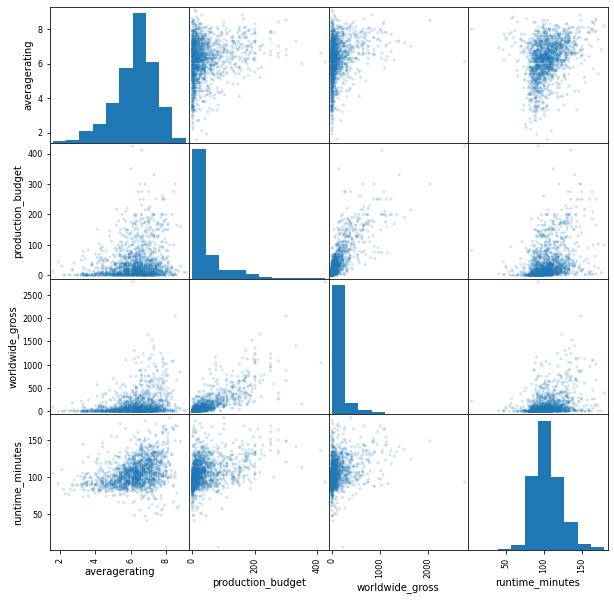

In [15]:
pd.plotting.scatter_matrix(imdbjoinratings[['averagerating','production_budget','worldwide_gross','runtime_minutes']], alpha=0.2, figsize=(10,10));

We can see that there seems to be a relationship between worldwide gross and production budget. Surprisingly the relationship between worldwide gross and average rating doesn't seem strong. I will take a closer look up these two columns to see if I can clean up the data to find a stronger correlation.

First I will plot out the production budget and worldwide gross columns then find the correlation coefficient.

# Is IMDB Rating a good indicator of Box Office Performance?

First I will plot out the production budget and worldwide gross columns then find the correlation coefficient.

0.7478641184716422
0.6869760798589295


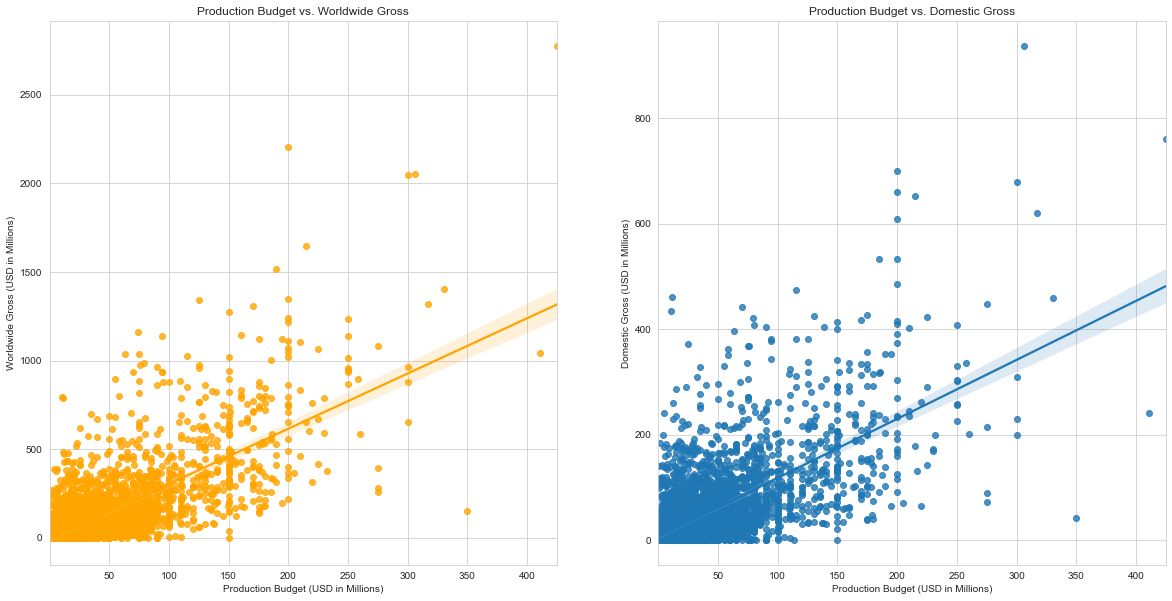

In [16]:
####Graph budget and worldwide gross
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,2,figsize=(20, 10))    
sns.regplot(data=budgetdf, x='production_budget', y='worldwide_gross', ax=ax[0], color='orange')
ax[0].set_ylabel('Worldwide Gross (USD in Millions)')
ax[0].set_xlabel('Production Budget (USD in Millions)')
ax[0].set_title('Production Budget vs. Worldwide Gross')

####Graph budget and domestic gross
sns.regplot(data=budgetdf, x='production_budget', y='domestic_gross', ax=ax[1])
ax[1].set_ylabel('Domestic Gross (USD in Millions)')
ax[1].set_xlabel('Production Budget (USD in Millions)')
ax[1].set_title('Production Budget vs. Domestic Gross')
###Find the correlation coefficient
print(np.corrcoef(budgetdf['production_budget'], budgetdf['worldwide_gross'])[1,0])
print(np.corrcoef(budgetdf['production_budget'], budgetdf['domestic_gross'])[1,0])


The Correlation Coefficient for production budget and worldwide gross is .748 and with domestic gross it is .686. Showing that there is some correlation between budget and gross.

Next I will take a look at the relationship between IMDB rating and gross.

0.249579654406696
0.2688523878018925


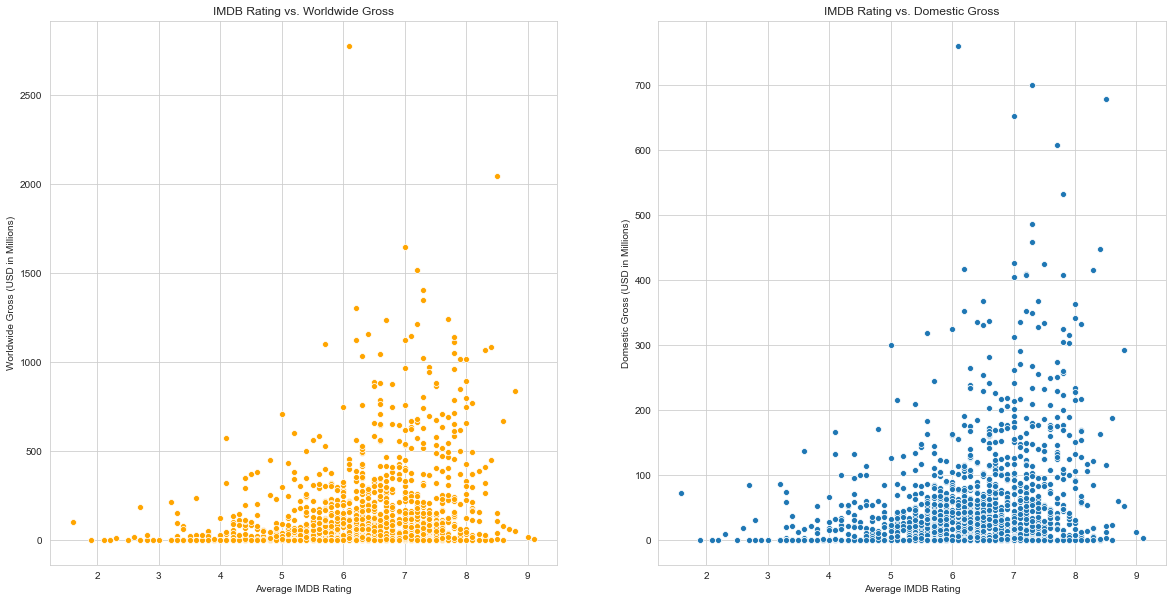

In [17]:
###graph rating and gross
fig, ax2 = plt.subplots(1,2, figsize=(20, 10))    
###Plot the graph between IMDB rating and Worldwide Gross
sns.scatterplot(data=imdbjoinratings, x='averagerating', y='worldwide_gross', ax=ax2[0], color='orange')
ax2[0].set_ylabel('Worldwide Gross (USD in Millions)')
ax2[0].set_xlabel('Average IMDB Rating')
ax2[0].set_title('IMDB Rating vs. Worldwide Gross')

###Plot the graph between IMDB rating and Domestic Gross
sns.scatterplot(data=imdbjoinratings, x='averagerating', y='domestic_gross', ax=ax2[1])
ax2[1].set_ylabel('Domestic Gross (USD in Millions)')
ax2[1].set_xlabel('Average IMDB Rating')
ax2[1].set_title('IMDB Rating vs. Domestic Gross')

###Correlation Coefficient between IMDB rating and Worldwide Gross
print(np.corrcoef(imdbjoinratings['averagerating'], imdbjoinratings['worldwide_gross'])[1,0])
print(np.corrcoef(imdbjoinratings['averagerating'], imdbjoinratings['domestic_gross'])[1,0])

##add budget to color hue

The correlation coefficient between IMDB Rating and gross is only 0.25 for worldwide and 0.269 for domestic. 

There doesn't seems to be much of a correlation between the two factors when we look at the data available to us.

Next I will drop the movies with less than 3000 votes to see if the low sample size is effecting the data.

0.2713889877423654
0.28948437026099616


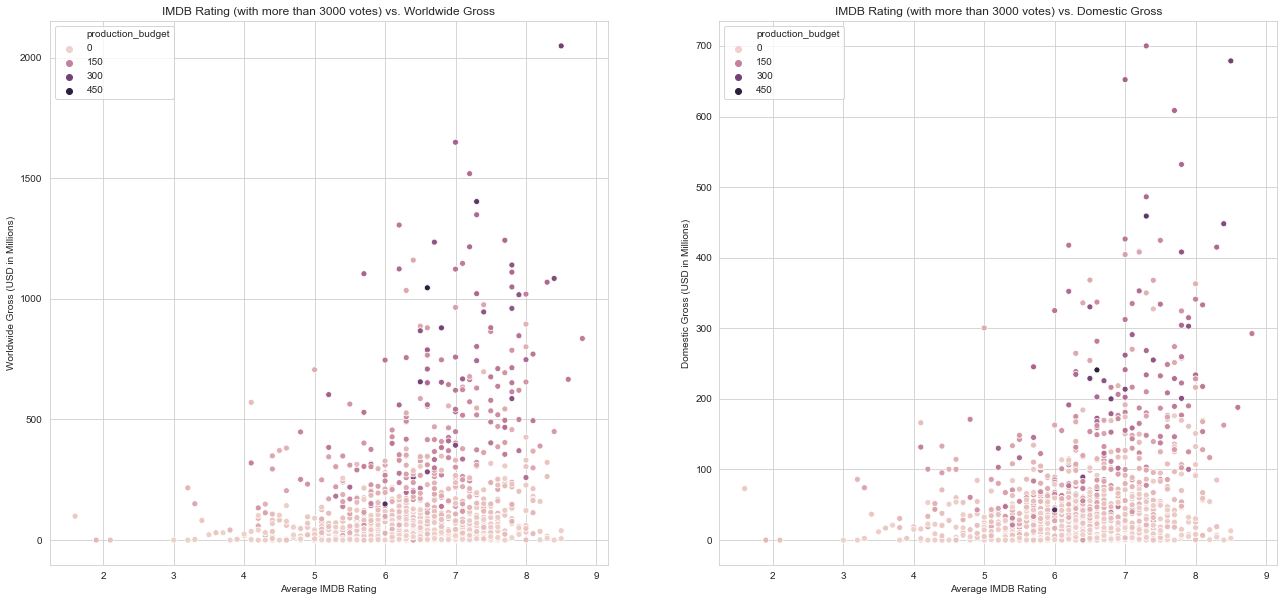

In [18]:
imdbjoinratings2 = imdbjoinratings.drop(index = imdbjoinratings[imdbjoinratings['numvotes'] < 3000].index)
fig, ax3 = plt.subplots(1, 2, figsize=(22,10))

###Plot the graph between IMDB rating (with more than 3000 votes) and Worldwide Gross
sns.scatterplot(data=imdbjoinratings2, x='averagerating', y='worldwide_gross', hue='production_budget', ax=ax3[0])
ax3[0].set_ylabel('Worldwide Gross (USD in Millions)')
ax3[0].set_xlabel('Average IMDB Rating')
ax3[0].set_title('IMDB Rating (with more than 3000 votes) vs. Worldwide Gross')

###Plot the graph between IMDB rating (with more than 3000 votes) and Domestic Gross
sns.scatterplot(data=imdbjoinratings2, x='averagerating', y='domestic_gross', hue='production_budget', ax=ax3[1])
ax3[1].set_ylabel('Domestic Gross (USD in Millions)')
ax3[1].set_xlabel('Average IMDB Rating')
ax3[1].set_title('IMDB Rating (with more than 3000 votes) vs. Domestic Gross')

print(np.corrcoef(imdbjoinratings2['averagerating'], imdbjoinratings2['worldwide_gross'])[1,0])
print(np.corrcoef(imdbjoinratings2['averagerating'], imdbjoinratings2['domestic_gross'])[1,0])


After dropping the movies with less than 3000 votes, the correlation between IMDB Rating and Worldwide Gross only improve to a .271. This doesn't change the initial assement that there is little correlation between IMDB Rating and Worldwide Gross

Adding the production budget to the hue shows that there might be a better correlation between the two factors for higher budgets films.

So first, let's investigated the production budget column. We see that 25th quartile is around 9 million.

In [19]:
imdbjoinratings2['production_budget'].describe()

count    1192.000000
mean       47.412378
std        57.834469
min         0.030000
25%        10.000000
50%        25.000000
75%        60.000000
max       410.600000
Name: production_budget, dtype: float64

0.3487918460375475
0.3809142293771149


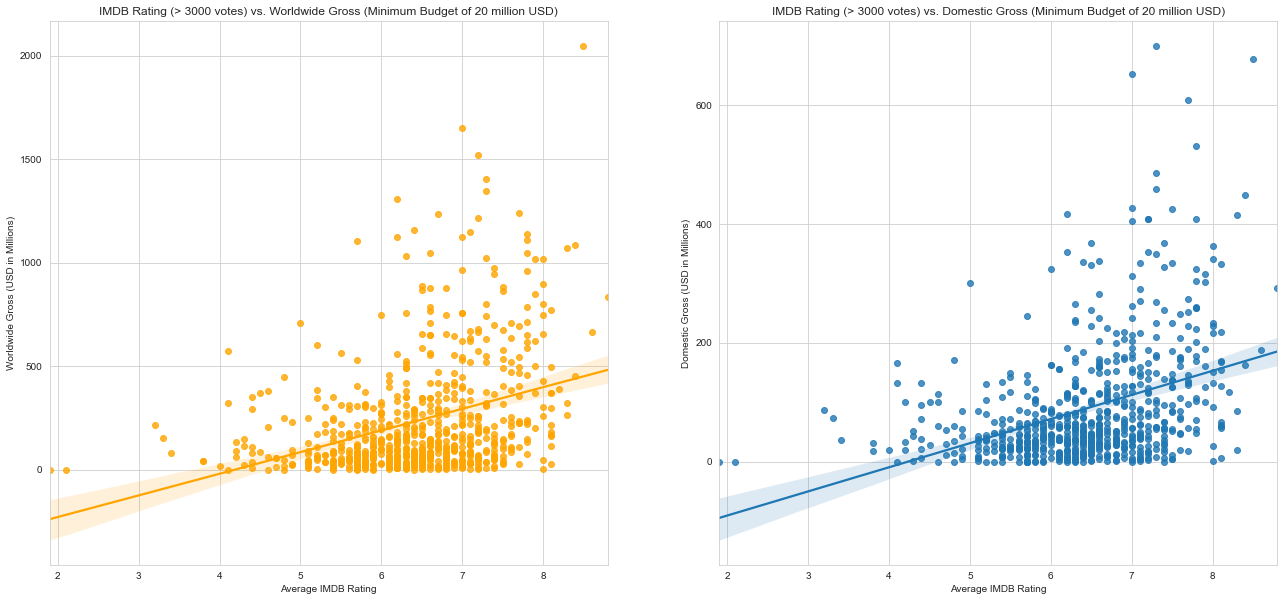

In [20]:
imdbjoinratings3 = imdbjoinratings2.drop(index = imdbjoinratings2[imdbjoinratings2['production_budget'] < 20].index)

fig, ax4 = plt.subplots(1, 2, figsize=(22,10))
sns.regplot(data=imdbjoinratings3, x='averagerating', y='worldwide_gross', ax=ax4[0], color='orange')
ax4[0].set_ylabel('Worldwide Gross (USD in Millions)')
ax4[0].set_xlabel('Average IMDB Rating')
ax4[0].set_title('IMDB Rating (> 3000 votes) vs. Worldwide Gross (Minimum Budget of 20 million USD)')

sns.regplot(data=imdbjoinratings3, x='averagerating', y='domestic_gross', ax=ax4[1])
ax4[1].set_ylabel('Domestic Gross (USD in Millions)')
ax4[1].set_xlabel('Average IMDB Rating')
ax4[1].set_title('IMDB Rating (> 3000 votes) vs. Domestic Gross (Minimum Budget of 20 million USD)')


#Find The Correlation Coefficient
print(np.corrcoef(imdbjoinratings3['averagerating'], imdbjoinratings3['worldwide_gross'])[1,0])
print(np.corrcoef(imdbjoinratings3['averagerating'], imdbjoinratings3['domestic_gross'])[1,0])


Even after raising the minimum budget to 20 million USD the correlation between average rating and gross doesn't seem to be strong. The correlation coefficent for both domestic and worldwide gross is still only around .37. It seems that IMDB rating is not a good indicator for box office performance.

So instead we will be taking a look at the movie genres and see which genres on average make the most at the box office.


# Which Genres draws the most audience to the theaters?

For this analysis I will use the IMDB database which have a genre columns and have more entries than the other datasets.

I use an inner join because I need both the genres column and the box office info from the two different datasets.

In [21]:
gen_gro_mergedf = imdbdf3.set_index('primary_title').join(budgetdf.set_index('movie'), how='inner')

gen_gro_mergedf.shape

(1728, 10)

In [22]:
gen_gro_mergedf

,tconst,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross
Foodfight!,tt0249516,Foodfight!,2012,91.0,"Action,Animation,Comedy",26,"Dec 31, 2012",45.0,0.000000,0.073706
Mortal Kombat,tt0293429,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy",10,"Aug 18, 1995",20.0,70.433227,122.133227
The Secret Life of Walter Mitty,tt0359950,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",37,"Dec 25, 2013",91.0,58.236838,187.861183
A Walk Among the Tombstones,tt0365907,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",67,"Sep 19, 2014",28.0,26.017685,62.108587
Jurassic World,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",34,"Jun 12, 2015",215.0,652.270625,1648.854864
...,...,...,...,...,...,...,...,...,...,...
Fuel,tt9678962,Fuel,2018,NaN,"Documentary,Sport",35,"Nov 14, 2008",2.5,0.174255,0.174255
Diner,tt9729206,Diner,2019,NaN,Crime,11,"Apr 2, 1982",5.0,12.592907,12.592907
Traitor,tt9805168,Traitor,2015,110.0,"Action,Drama,Romance",25,"Aug 27, 2008",22.0,23.530831,27.882226
Ray,tt9844102,Ray,2018,111.0,Crime,8,"Oct 29, 2004",40.0,75.305995,124.823094


Next we investigate the dataframe to see if there are missing entries in the 'genres' and 'worldwide_gross' columns.

In [23]:
###Get rid of row with na in genre column
print(gen_gro_mergedf['genres'].isna().sum())
print(gen_gro_mergedf['worldwide_gross'].isna().sum())





13
0


Since there are only 13 rows with the genre missing, I decided to drop all of these rows.

In [24]:
nafilt = gen_gro_mergedf['genres'].isna()
gen_gro_mergedf = gen_gro_mergedf.drop(index = gen_gro_mergedf[nafilt].index)
print(gen_gro_mergedf['genres'].isna().sum())
gen_gro_mergedf['genres'].nunique()

0


269

In [25]:
### Split Genres strings into lists
gen_gro_mergedf['genres'] = gen_gro_mergedf['genres'].apply(lambda x: x.split(','))

### Split the list of genres
genres_gross_df = gen_gro_mergedf[['genres', 'worldwide_gross']]
genres_gross_df = genres_gross_df.explode('genres')
genres_gross_dftest = gen_gro_mergedf[['genres', 'worldwide_gross']]

Since there are rows with multiple genres given as a single string, I need to split them using the .split() method. After I used the .explode() method so that each row only contain one genre.

After that I use the groupby() method on genres so that I can graph their informations.

Text(0.5, 1.0, 'Median Worldwide Gross for Genres')

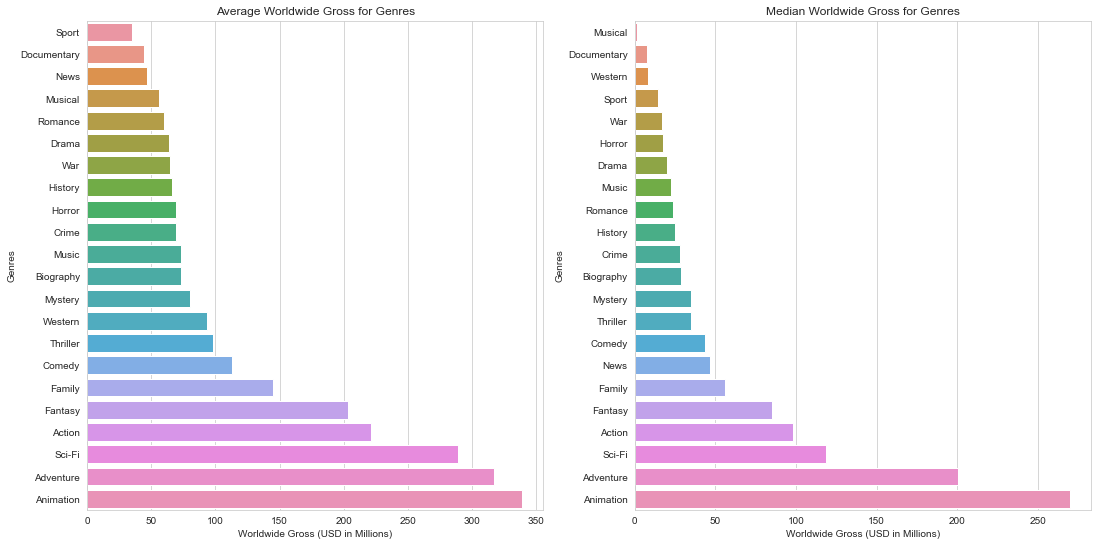

In [26]:
###Grouping the genres, finding the mean and sorting so that we can plot
genres_mean = genres_gross_df.groupby('genres').mean()
genres_mean = genres_mean.reset_index()
genres_mean.sort_values(by = 'worldwide_gross', inplace=True)
###Grouping the genres, finding the mean and sorting so that we can plot
genres_median = genres_gross_df.groupby('genres').median()
genres_median = genres_median.reset_index()
genres_median.sort_values(by = 'worldwide_gross', inplace=True)

###Plot the graphs
fig, ax = plt.subplots(1,2, figsize =(18,9))

### Plot the Average Worldwide Gross of each genre
sns.barplot(data=genres_mean, y='genres', x='worldwide_gross', ax=ax[0])
ax[0].set_ylabel('Genres')
ax[0].set_xlabel('Worldwide Gross (USD in Millions)')
ax[0].set_title('Average Worldwide Gross for Genres')
     
### Plot the Median Worldwide Gross of each genre
sns.barplot(data=genres_median, y='genres', x='worldwide_gross', ax=ax[1])
ax[1].set_ylabel('Genres')
ax[1].set_xlabel('Worldwide Gross (USD in Millions)')
ax[1].set_title('Median Worldwide Gross for Genres')   

We can see that overall Animation and Adventure films do very well, follow closely Action, SciFic and Fantasy.

Next let's take a look at the imdb ratings for genres to see what kind of movies the audience enjoys the most.


In [27]:
genresratingsdf = imdbdf3.set_index('tconst').join(ratingsdf.set_index('tconst'), how='inner')
genresratingsdf = genresratingsdf.drop(index = genresratingsdf[genresratingsdf['genres'].isna()].index)
genresratingsdf['genres'] = genresratingsdf['genres'].apply(lambda x: x.split(','))
genresratingsdf.reset_index(inplace=True)
genresratingsdf = genresratingsdf.explode('genres')

genresratingsdf = genresratingsdf.drop(index = genresratingsdf[genresratingsdf['numvotes'] < 3000].index)
genRatGrp = genresratingsdf.groupby('genres')

toplot2 = genresratingsdf[['genres', 'averagerating']]

Text(0, 0.5, 'Genres')

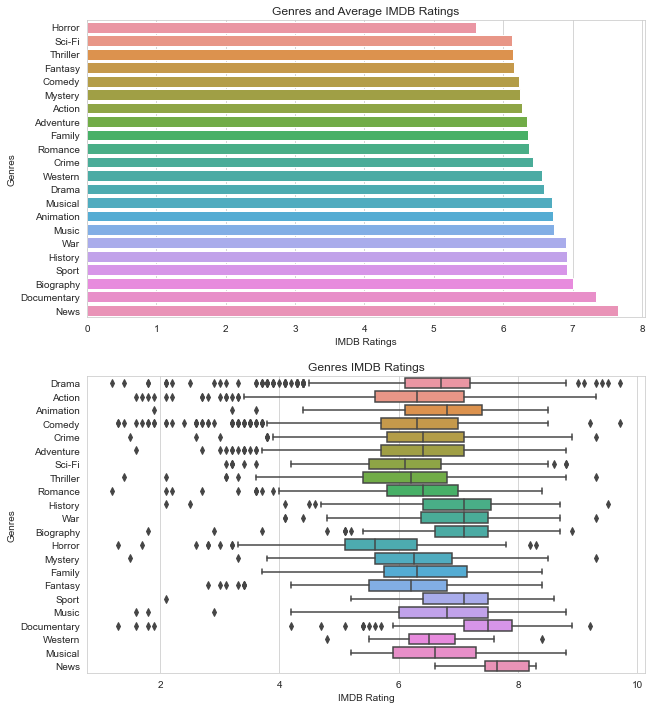

In [28]:
toplot = genRatGrp['averagerating'].mean().reset_index().sort_values(by='averagerating')

fig, ax8 = plt.subplots(2, 1, figsize=(10,12))
sns.barplot(data=toplot, x='averagerating', y='genres', ax=ax8[0])
ax8[0].set_title('Genres and Average IMDB Ratings')
ax8[0].set_xlabel('IMDB Ratings')
ax8[0].set_ylabel('Genres')


sns.boxplot(data=toplot2, x='averagerating', y='genres',ax=ax8[1])
ax8[1].set_title('Genres IMDB Ratings')
ax8[1].set_xlabel('IMDB Rating')
ax8[1].set_ylabel('Genres')

# Who are the Highest Grossing Directors since 2010?

A movie directror can be credited as having the most influence on the final product so choosing the right person is an extremely important decision.

We clean up the data so that we have the director name for each films, and make sure the gross information is available. Then we used the grouby method() again analyze the data. Since we will also be taking a look at the average gross, I decided to get rid of the directors with only one or less movie under their name.

In [29]:
###Drop rows with no director entries, split the multiple director films, join with movie titles
imdbcrewdirector = imdbcrew.drop(index = imdbcrew[imdbcrew['directors'].isna()].index)
imdbcrewdirector['directors'] = imdbcrewdirector['directors'].apply(lambda x: x.split(','))
imdbcrewdirector = imdbcrewdirector.set_index('tconst').join(imdbdf3.set_index('tconst'))
imdbcrewdirector.reset_index(inplace=True)

###Join the box office info dataset to the list of movie titles
imdbcrewdirector = imdbcrewdirector.set_index('original_title').join(budgetdf.set_index('movie'), how='inner')
imdbcrewdirector.reset_index(inplace=True)

###Drop entries with 0 for worldwide gross
imdbcrewdirector = imdbcrewdirector.drop(index = imdbcrewdirector[imdbcrewdirector['worldwide_gross']==0].index)
imdbcrewdirector = imdbcrewdirector.explode('directors')

###Join the dataset with the names of the directors
imdbstaff_names_codes = imdbstaff[['nconst','primary_name']]
imdbcrewdirector = imdbcrewdirector.set_index('directors').join(imdbstaff_names_codes.set_index('nconst'), how='inner')
imdbcrewdirector.reset_index(inplace=True)



Text(0, 0.5, 'Directors')

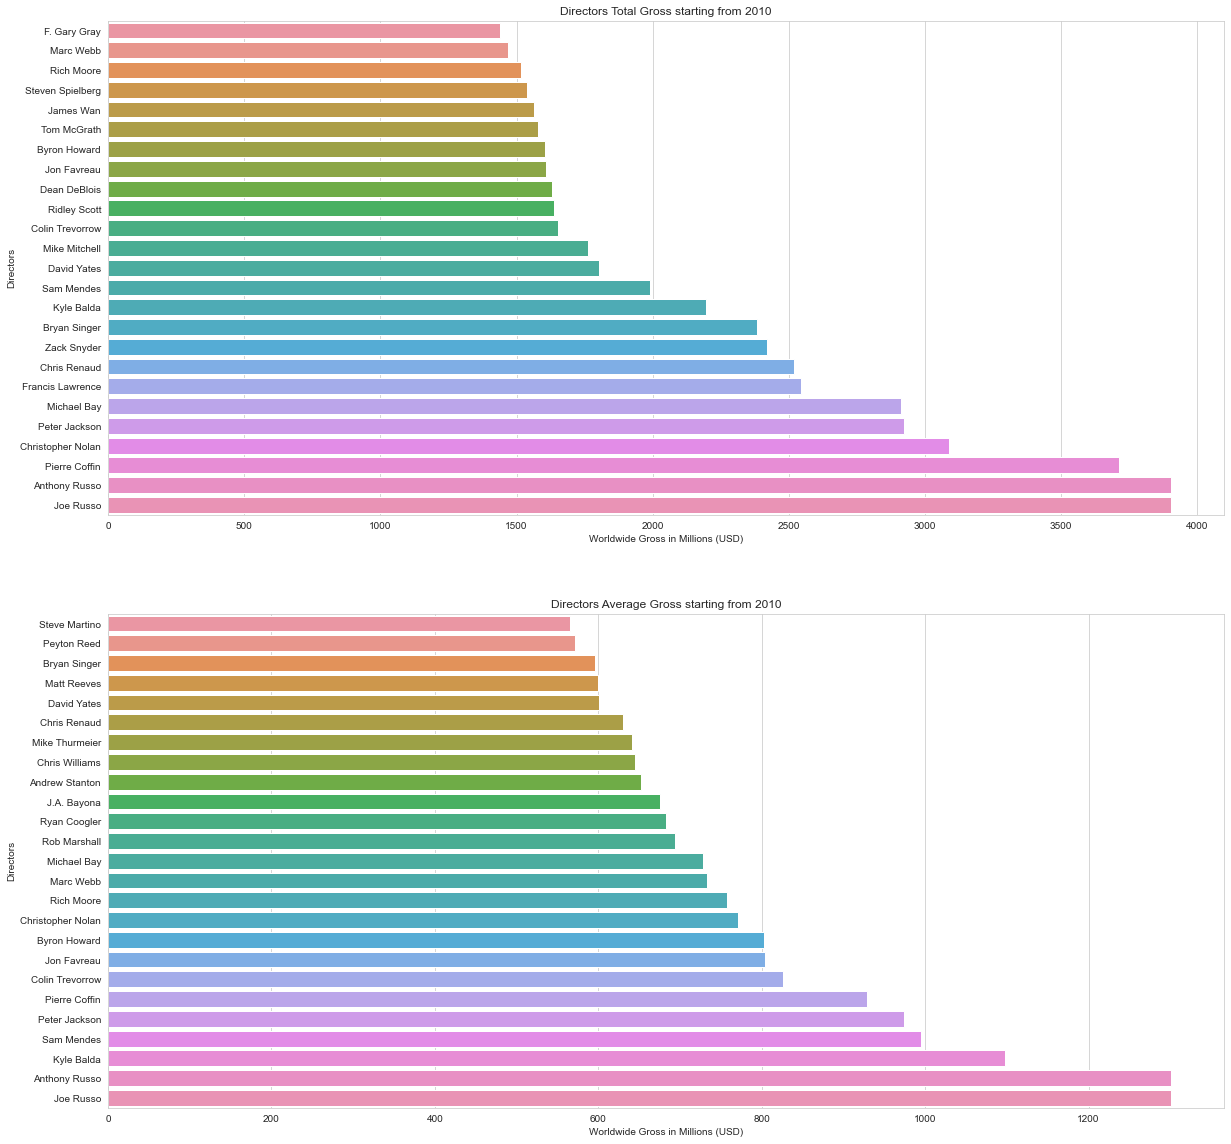

In [30]:
###Get rid of directors with only one movie to get the ones with more credentials

valcount = imdbcrewdirector['primary_name'].value_counts()
valcount_remove = valcount[valcount <= 1].index
imdbcrewdirector = imdbcrewdirector[~imdbcrewdirector['primary_name'].isin(valcount_remove)]

### Movies only starting from 2010
directorgrp = imdbcrewdirector.groupby('primary_name')

dir_a1 = directorgrp.sum().reset_index()
dir_a2 = dir_a1.sort_values(by='worldwide_gross', ascending=False)[0:25]
fig, ax5 = plt.subplots(2, 1, figsize=(20,20))
###Plot Directors Total Gross
sns.barplot(data=dir_a2.sort_values(by='worldwide_gross', ascending=True), x='worldwide_gross', y='primary_name', ax=ax5[0])
ax5[0].set_title('Directors Total Gross starting from 2010')
ax5[0].set_xlabel('Worldwide Gross in Millions (USD)')
ax5[0].set_ylabel('Directors')

dir_b1 = directorgrp.mean().reset_index()
dir_b2 = dir_b1.sort_values(by='worldwide_gross', ascending=False)[0:25]
sns.barplot(data=dir_b2.sort_values(by='worldwide_gross', ascending=True), x='worldwide_gross', y='primary_name', ax=ax5[1])
ax5[1].set_title('Directors Average Gross starting from 2010')
ax5[1].set_xlabel('Worldwide Gross in Millions (USD)')
ax5[1].set_ylabel('Directors')

Above are the graphs for the top grossing movie directors starting from 2010. A new movie production company might want to hire a experienced director who have great track record in recent years to make sure their first few films are sucessful. Taking a chance on a new up and coming director is risky and propably should only be done after the production company is well established.

Any of the directors shown on the graph up can be trusted to lead the project.


Next I will also be taking a look at the directors who have the most films on IMDB.

In [31]:
###Drop rows with no director entries, split the multiple director films, join with ratings
imdbcrewdirector2 = imdbcrew.drop(index = imdbcrew[imdbcrew['directors'].isna()].index)
imdbcrewdirector2['directors'] = imdbcrewdirector2['directors'].apply(lambda x: x.split(','))
imdbcrewdirector2 = imdbcrewdirector2.set_index('tconst').join(ratingsdf.set_index('tconst'))
imdbcrewdirector2.reset_index(inplace=True)
imdbcrewdirector2 = imdbcrewdirector2.explode('directors')

###Join id codes with names
imdbcrewdirector2 = imdbcrewdirector2.set_index('directors').join(imdbstaff_names_codes.set_index('nconst'), how='inner')
imdbcrewdirector2.reset_index(inplace=True)

###Drop rows with no ratings
imdbcrewdirector2 = imdbcrewdirector2.drop(index = imdbcrewdirector2[imdbcrewdirector2['averagerating'].isna()].index)
###Drop rows with less than 3000
imdbcrewdirector2 = imdbcrewdirector2.drop(index = imdbcrewdirector2[imdbcrewdirector2['numvotes'] < 3000].index)

###Drop directors with less than 3 movies
valcount4 = imdbcrewdirector2['primary_name'].value_counts()
valcount_remove = valcount4[valcount4 <= 3].index
imdbcrewdirector2 = imdbcrewdirector2[~imdbcrewdirector2['primary_name'].isin(valcount_remove)]

directorgrp2 = imdbcrewdirector2.groupby('primary_name')

In [32]:
###Prepare data for plotting
director_ratings = directorgrp2['averagerating'].mean().reset_index().sort_values(by='averagerating', ascending=False)[0:25]
directorlist = director_ratings['primary_name']
directorlist = directorlist.values.tolist()

imdbcrewdirector2 = imdbcrewdirector2[imdbcrewdirector2['primary_name'].isin(directorlist)]


Text(0, 0.5, 'Directors')

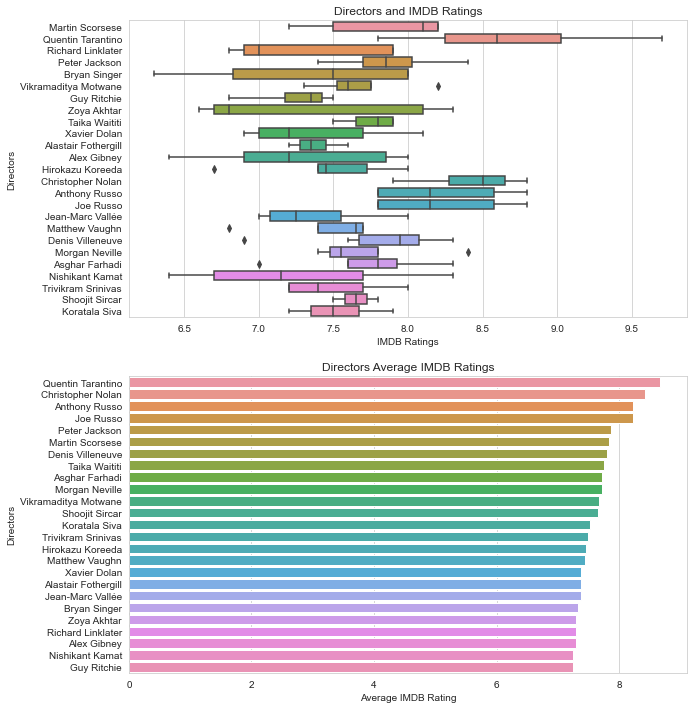

In [33]:
fig, ax7 = plt.subplots(2, 1, figsize=(10,12))

###Plot Directors IMDB Ratings
sns.boxplot(data=imdbcrewdirector2, x='averagerating', y='primary_name', ax=ax7[0])
ax7[0].set_title('Directors and IMDB Ratings')
ax7[0].set_xlabel('IMDB Ratings')
ax7[0].set_ylabel('Directors')

###Plot Directors Average IMDB Ratings

sns.barplot(data=director_ratings, x='averagerating', y='primary_name', ax=ax7[1])
ax7[1].set_title('Directors Average IMDB Ratings')
ax7[1].set_xlabel('Average IMDB Rating')
ax7[1].set_ylabel('Directors')


Since critical acclaim is also important for a movie studio reputation and success, the directors listed above also make good choices to lead the films.

# Highest Grossing Writers?

A successful film have to start with a good script, so next we will be taking a look at the writers of these films.

I will clean up the data using the same methods that I used for directos.

In [34]:
###Drop rows with no writer entries, split the multiple writer films, join with movie titles
imdbcrewwriters = imdbcrew.drop(index= imdbcrew[imdbcrew['writers'].isna()].index)
imdbcrewwriters['writers'] = imdbcrewwriters['writers'].apply(lambda x: x.split(','))
imdbcrewwriters = imdbcrewwriters.set_index('tconst').join(imdbdf3.set_index('tconst'))
imdbcrewwriters.reset_index(inplace=True)

###Join the box office info dataset to the list of movie titles
imdbcrewwriters = imdbcrewwriters.set_index('original_title').join(budgetdf.set_index('movie'), how='inner')
imdbcrewwriters.reset_index(inplace=True)

###Drop entries with 0 for worldwide gross
imdbcrewwriters = imdbcrewwriters.drop(index = imdbcrewwriters[imdbcrewwriters['worldwide_gross']==0].index)
imdbcrewwriters = imdbcrewwriters.explode('writers')

###Join the dataset with the names of the writers
imdbcrewwriters = imdbcrewwriters.set_index('writers').join(imdbstaff_names_codes.set_index('nconst'), how='inner')
imdbcrewwriters.reset_index(inplace=True)
imdbcrewwriters.rename(columns={'primary_name': 'writers'}, inplace=True)

###Get rid of writers with less than two movie to get the ones with more credentials
valcount2 = imdbcrewwriters['writers'].value_counts()
valcount_remove2 = valcount2[valcount2 <= 2].index
imdbcrewwriters = imdbcrewwriters[~imdbcrewwriters['writers'].isin(valcount_remove2)]
###Use groupby method
writergrp = imdbcrewwriters.groupby('writers')

Text(0, 0.5, 'Writers')

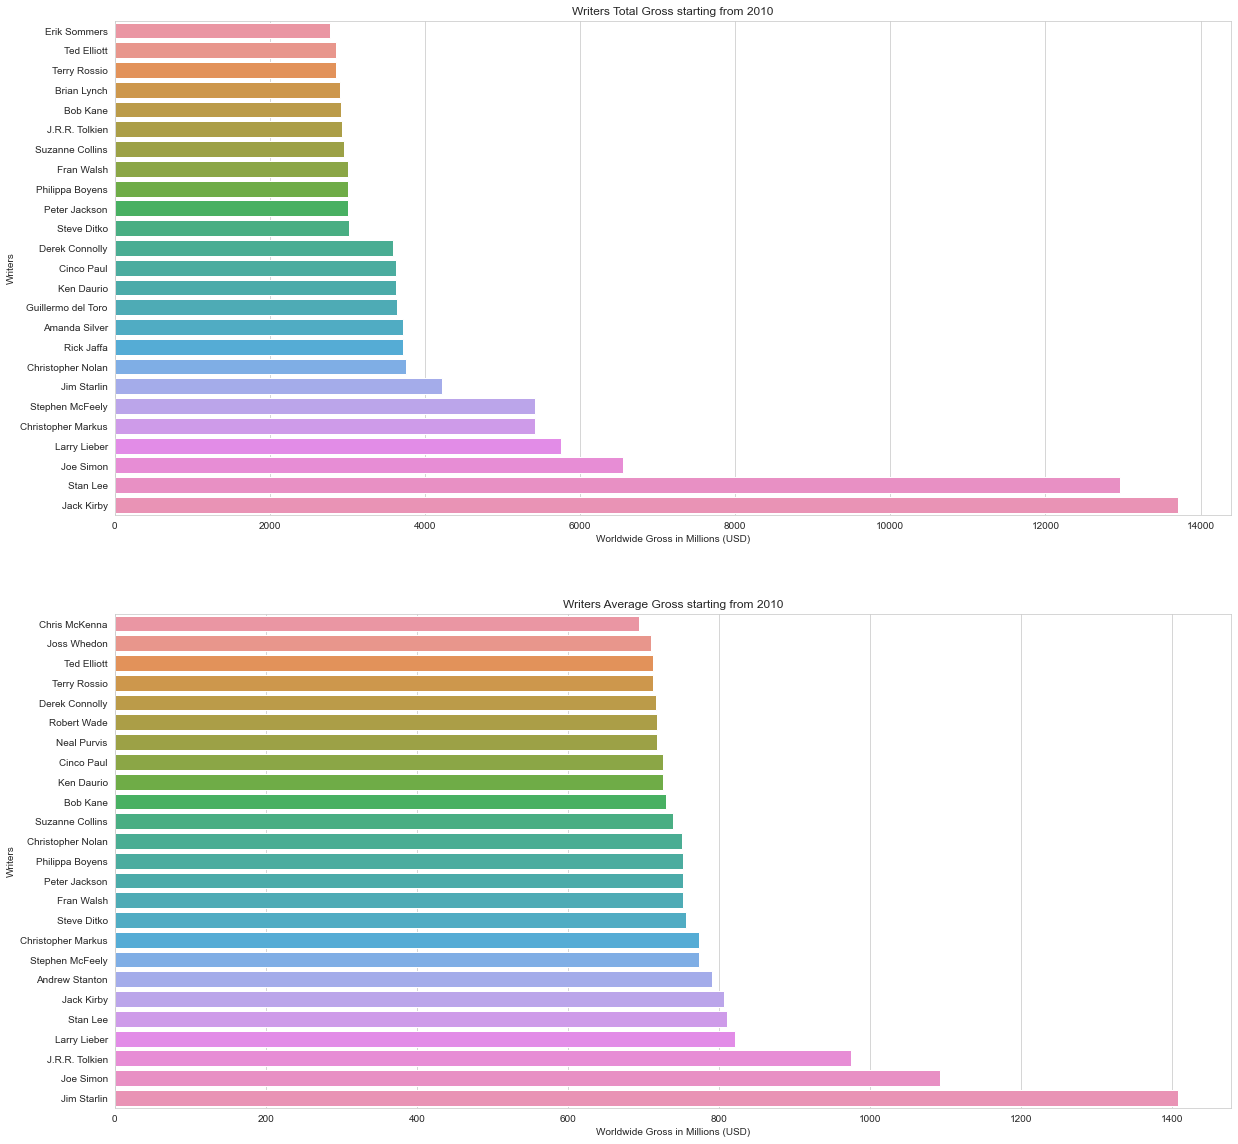

In [35]:
wri_a1 = writergrp.sum().reset_index()
wri_a2 = wri_a1.sort_values(by='worldwide_gross', ascending=False)[0:25]
fig, ax6 = plt.subplots(2, 1, figsize=(20,20))
###Plot Writers Total Gross
sns.barplot(data=wri_a2.sort_values(by='worldwide_gross', ascending=True), x='worldwide_gross', y='writers', ax=ax6[0])
ax6[0].set_title('Writers Total Gross starting from 2010')
ax6[0].set_xlabel('Worldwide Gross in Millions (USD)')
ax6[0].set_ylabel('Writers')

###Plot Writers Average Gross
wri_b1 = writergrp.mean().reset_index()
wri_b2 = wri_b1.sort_values(by='worldwide_gross', ascending=False)[0:25]
sns.barplot(data=wri_b2.sort_values(by='worldwide_gross', ascending=True), x='worldwide_gross', y='writers', ax=ax6[1])
ax6[1].set_title('Writers Average Gross starting from 2010')
ax6[1].set_xlabel('Worldwide Gross in Millions (USD)')
ax6[1].set_ylabel('Writers')



The writer list is dominated by authors and comic books writer including those who are no longer alive but are credited for creating the characters and franchises.

It would be better for the analysis if the writers are limited exclusively to the screenplay writers but such data is not available with the give datasets.

# Which actors does the audience want to see the most?

Although a few writers and directors can convince the audience to go to the theaters just from their name value, historically the biggest box offices draws have been the actors and actresscess.

In [36]:
### Isolate the actors and actress list. Add names to the id codes.
imdb_actors = imdbcrew2[imdbcrew2['category'].isin(['actor', 'actress'])]
imdb_actors = imdb_actors.set_index('nconst').join(imdbstaff.set_index('nconst'))
imdb_actors.reset_index(inplace=True)
### Join the names and roles to the movie name dataset
imdb_actors = imdb_actors.set_index('tconst').join(imdbdf3.set_index('tconst'))
imdb_actors.reset_index(inplace=True)
imdb_actors.rename(columns={'primary_name':'actor'}, inplace=True)

### Join the box office info dataset
imdb_actors = imdb_actors.set_index('primary_title').join(budgetdf.set_index('movie'), how='inner')
imdb_actors.reset_index(inplace=True)
imdb_actors = imdb_actors.drop(index = imdb_actors[imdb_actors['worldwide_gross']==0].index)


Since actors can appear in non main charactersroles looking at the average gross could be misleading. To fix this I will increase the minimum movie count to 3.

In [37]:
valcount3 = imdb_actors['actor'].value_counts()
valcount_remove3 = valcount3[valcount3 <= 3].index
imdb_actors = imdb_actors[~imdb_actors['actor'].isin(valcount_remove3)]

### Groupby Actors
actor_grp = imdb_actors.groupby('actor')
act_a1 = actor_grp.sum().reset_index()
act_a2 = act_a1.sort_values(by='worldwide_gross', ascending=False)[0:25]

act_b1 = actor_grp.mean().reset_index()
act_b2 = act_b1.sort_values(by='worldwide_gross', ascending=False)[0:25]

Text(0, 0.5, 'Actors/Actress')

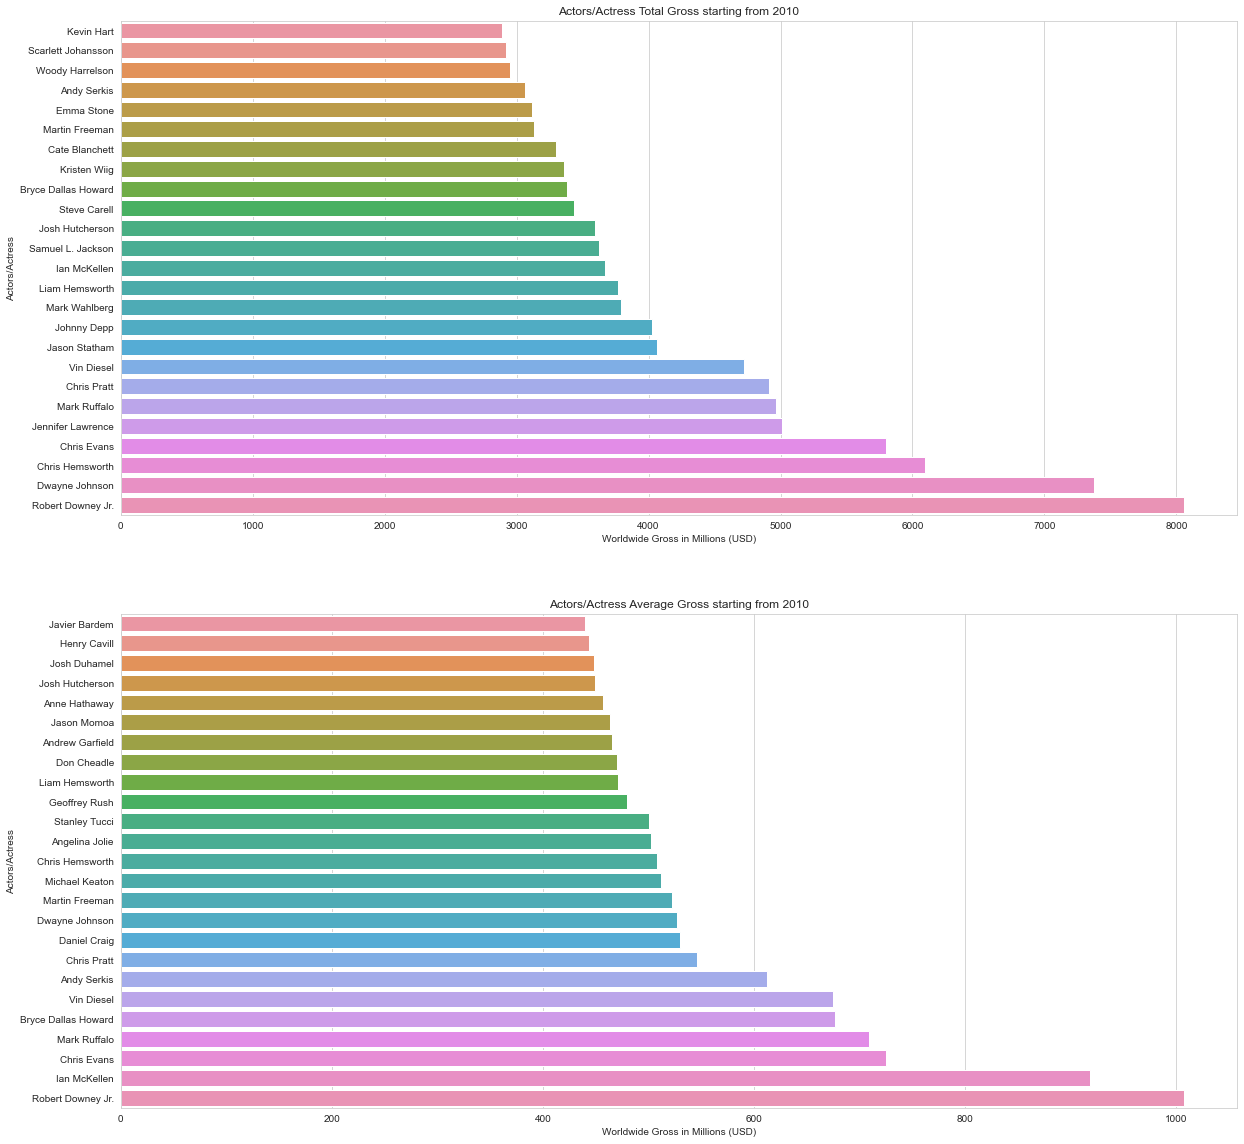

In [38]:
###Plot Actors Total Gross
fig, ax7 = plt.subplots(2, 1, figsize=(20,20))

sns.barplot(data=act_a2.sort_values(by='worldwide_gross', ascending=True), x='worldwide_gross', y='actor', ax=ax7[0])
ax7[0].set_title('Actors/Actress Total Gross starting from 2010')
ax7[0].set_xlabel('Worldwide Gross in Millions (USD)')
ax7[0].set_ylabel('Actors/Actress')


sns.barplot(data=act_b2.sort_values(by='worldwide_gross', ascending=True), x='worldwide_gross', y='actor', ax=ax7[1])
ax7[1].set_title('Actors/Actress Average Gross starting from 2010')
ax7[1].set_xlabel('Worldwide Gross in Millions (USD)')
ax7[1].set_ylabel('Actors/Actress')

Looking at the data we once again see that the box office in the last decade have been dominated by Marvel Cinematic Universe and a few other franchises.

It seems that the days of actors being the main reason people go to the theaters are no longer true. I would say only a handful of the actors listed above can be call box office draws.

It is difficult to empirically break down which actor and actress can be credited as being the main reason for ticket sales.



# Recommendation

Looking at the data and graphs of the highest grossing actors, directors and writers it is evident that the biggest box office draws are franchises.

1. Therefore for biggest box office sucess, the production company should try to create a franchise that falls in the genres of Animation, Adventure, Action, Sci-Fic, and Fantasy.


2. If possibe the studio should try to aquire the rights to an established source material since it is evident that franchises based on books and comics have the most success.


3. Any of the directors that were among the top grossing in the last decade have tremendous experience and can be trusted to lead a brand new project.


4. Household name cast should be targeted for casting since this were initially bring a lot of audience, and then it's up to the franchise keep them interested.